In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./input_root'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./input_root/nomold/istockphoto-1350656142-612x612_jpg.rf.13673836b710f3f74437253558836675.jpg
./input_root/nomold/1700405211111_jpg.rf.7246575fded2fc6a8ef1ab41ea99bc71.jpg
./input_root/nomold/basement0038_jpg.rf.ead053c1c4ce272255b4c8f93654b201.jpg
./input_root/nomold/basement0097_jpg.rf.16a5c326def934e98534d68e30b63953.jpg
./input_root/nomold/istockphoto-1206812822-612x612_jpg.rf.84c6e9857412bda702b6938e1379c1c2.jpg
./input_root/nomold/floor-cleaning-liquid_webp.rf.9284d00c87572e84f6469cb9b0881617.jpg
./input_root/nomold/istockphoto-1093845210-612x612_jpg.rf.0f47a3cac80ff233784312628022e866.jpg
./input_root/nomold/istockphoto-1253261470-612x612_jpg.rf.0231c88b77fc06f66557b3eeda4577bc.jpg
./input_root/nomold/istockphoto-1128687594-612x612_jpg.rf.ae3c7eac3c6a4a327b17f92817bbf5de.jpg
./input_root/nomold/001-050_jpeg_jpg.rf.238dec8ed12c8f56688987b9f609ebfb.jpg
./input_root/nomold/basement0039_jpg.rf.07f29314a2ee433ec9ff182a65562526.jpg
./input_root/nomold/ADE_val_00001937_jpg.rf.e36922b0

In [5]:
import os
import random
from glob import glob
from sklearn.model_selection import train_test_split
import shutil

# -------------------------
# PATHS
# -------------------------
dataset_root = "./input_root"   # your mold + nomold folder
output_root = "./output_root"

classes = ["mold", "nomold"]
os.makedirs(output_root, exist_ok=True)

# Output structure
for split in ["train", "val", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(output_root, split, cls), exist_ok=True)

# -------------------------
# BALANCING DATASET
# -------------------------
mold_imgs = glob(os.path.join(dataset_root, "mold", "*"))
nomold_imgs = glob(os.path.join(dataset_root, "nomold", "*"))

min_count = min(len(mold_imgs), len(nomold_imgs))

print("Mold images:    ", len(mold_imgs))
print("No-mold images: ", len(nomold_imgs))
print("Using balanced size:", min_count)

# Take equal random samples
mold_imgs = random.sample(mold_imgs, min_count)
nomold_imgs = random.sample(nomold_imgs, min_count)

all_data = [(img, 0) for img in mold_imgs] + [(img, 1) for img in nomold_imgs]

# -------------------------
# SPLIT into train/val/test
# -------------------------
train_data, temp_data = train_test_split(all_data, test_size=0.3, random_state=42, stratify=[c for _, c in all_data])
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=[c for _, c in temp_data])

print("Train:", len(train_data))
print("Val:", len(val_data))
print("Test:", len(test_data))

# -------------------------
# COPY FILES TO NEW FOLDERS
# -------------------------
def copy_files(data, split_name):
    for img, label in data:
        cls = classes[label]  # mold or nomold
        dest = os.path.join(output_root, split_name, cls)
        shutil.copy(img, dest)

copy_files(train_data, "train")
copy_files(val_data, "val")
copy_files(test_data, "test")

print("✅ Dataset successfully split and balanced!!")
print("Saved to:", output_root)


Mold images:     56
No-mold images:  60
Using balanced size: 56
Train: 78
Val: 17
Test: 17
✅ Dataset successfully split and balanced!!
Saved to: ./output_root


In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
    ]),
    "val": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
    "test": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ])
}

data_dir = output_root

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ["train", "val", "test"]}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=2)
               for x in ["train", "val", "test"]}

class_names = image_datasets["train"].classes
print("Classes:", class_names)


Classes: ['mold', 'nomold']


Split dataset already exists at: ./output_root
Classes: ['mold', 'nomold']
Dataset sizes: {'train': 78, 'val': 33, 'test': 31}
SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3,

/home/ms/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/25 — train_loss: 0.6701, train_acc: 0.5641, val_loss: 0.6868, val_acc: 0.5455, time: 5.2s
Saved new best model (val_acc=0.5455) -> ./models/mold_cnn_best.pth
Epoch 2/25 — train_loss: 0.5648, train_acc: 0.7949, val_loss: 0.6828, val_acc: 0.5455, time: 5.0s
Epoch 3/25 — train_loss: 0.5113, train_acc: 0.7949, val_loss: 0.6872, val_acc: 0.5455, time: 4.8s
Epoch 4/25 — train_loss: 0.4598, train_acc: 0.8462, val_loss: 0.6890, val_acc: 0.5455, time: 4.3s
Epoch 5/25 — train_loss: 0.4392, train_acc: 0.8205, val_loss: 0.6838, val_acc: 0.5758, time: 4.4s
Saved new best model (val_acc=0.5758) -> ./models/mold_cnn_best.pth
Epoch 6/25 — train_loss: 0.4232, train_acc: 0.8205, val_loss: 0.6726, val_acc: 0.6061, time: 4.5s
Saved new best model (val_acc=0.6061) -> ./models/mold_cnn_best.pth
Epoch 7/25 — train_loss: 0.3822, train_acc: 0.8333, val_loss: 0.6356, val_acc: 0.6970, time: 4.5s
Saved new best model (val_acc=0.6970) -> ./models/mold_cnn_best.pth
Epoch 8/25 — train_loss: 0.3960, train_acc

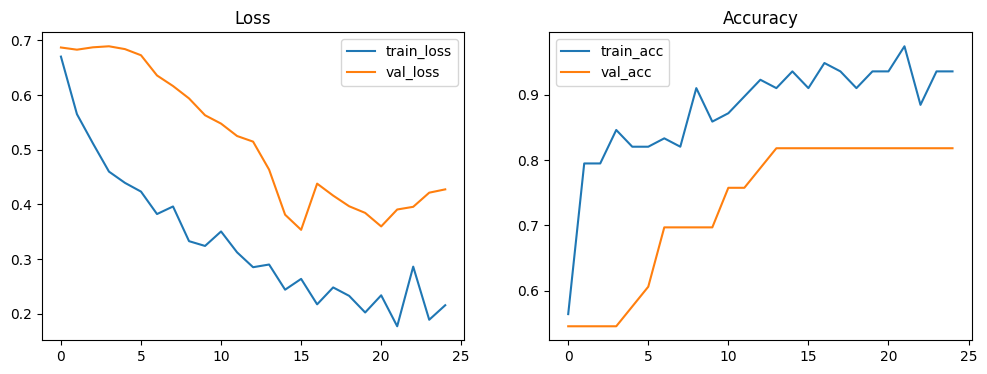

Saved training curves to ./working/training_curves.png
Test accuracy: 0.9032
Classification report:
              precision    recall  f1-score   support

        mold       1.00      0.80      0.89        15
      nomold       0.84      1.00      0.91        16

    accuracy                           0.90        31
   macro avg       0.92      0.90      0.90        31
weighted avg       0.92      0.90      0.90        31



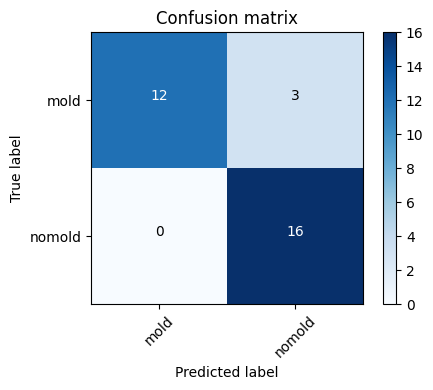

Saved confusion matrix to ./working/confusion_matrix.png
Zipped artifacts at ./working/mold_cnn_artifacts.zip (contains curves and confusion matrix and model)
Inference function ready. Example usage:
Sample inference on: ./output_root/train/mold/0_ang_wlp_wl20134837_5jpg_jpg.rf.eba62f71bed38b3b5cf519af2ae1dcb5.jpg
{'pred_index': 1, 'pred_label': 'nomold', 'probs': array([0.49539617, 0.50460386], dtype=float32)}
Sample inference on: ./output_root/val/mold/8-sanytol-mold-1024x612_jpg.rf.c1b60d8da405cdf01fa95cd266d0d0a5.jpg
{'pred_index': 1, 'pred_label': 'nomold', 'probs': array([0.08838181, 0.9116181 ], dtype=float32)}
Sample inference on: ./output_root/test/mold/0_black-mould-in-a-house_jpg.rf.1dab28127ddce1b6b43f370c63fd0f7a.jpg
{'pred_index': 1, 'pred_label': 'nomold', 'probs': array([0.40381378, 0.5961862 ], dtype=float32)}
All done — model, curves and artifacts are in ./working/. You can download the model at: ./models/mold_cnn_best.pth


In [10]:
# Complete PyTorch training + eval + inference pipeline for small CNN (Kaggle-ready)
import os, random, shutil, time
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools

# -----------------------------
# User-editable paths & params
# -----------------------------
dataset_root_input = "./input_root"   # original dataset with mold/nomold (if split missing)
split_root = "./output_root"         # where we'll put train/val/test
batch_size = 16
image_size = 224
num_epochs = 25
seed = 42
num_workers = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "./models/mold_cnn_best.pth"

# -----------------------------
# 1) Prepare balanced splits (if not exists)
# -----------------------------
def prepare_splits(src_root, out_root, seed=42, test_size=0.3, val_ratio=0.5):
    import os, random, shutil
    from glob import glob
    random.seed(seed)
    classes = ["mold", "nomold"]
    # create structure
    for split in ["train","val","test"]:
        for c in classes:
            os.makedirs(os.path.join(out_root, split, c), exist_ok=True)
    # gather images
    mold_imgs = sorted(glob(os.path.join(src_root, "mold", "*")))
    nomold_imgs = sorted(glob(os.path.join(src_root, "nomold", "*")))
    if len(mold_imgs) == 0 or len(nomold_imgs) == 0:
        raise RuntimeError(f"Source dataset not found or empty: {src_root}")
    # balance
    min_count = min(len(mold_imgs), len(nomold_imgs))
    mold_imgs = random.sample(mold_imgs, min_count)
    nomold_imgs = random.sample(nomold_imgs, min_count)
    all_data = [(p, "mold") for p in mold_imgs] + [(p, "nomold") for p in nomold_imgs]
    labels = [0]*len(mold_imgs) + [1]*len(nomold_imgs)
    # stratified split
    train_data, temp_data = train_test_split(all_data, test_size=test_size, random_state=seed, stratify=[1 if c=="nomold" else 0 for _,c in all_data])
    val_data, test_data = train_test_split(temp_data, test_size=val_ratio, random_state=seed, stratify=[1 if c=="nomold" else 0 for _,c in temp_data])
    # copy
    def copy_list(data, split_name):
        for src_path, cls in data:
            dst = os.path.join(out_root, split_name, cls, os.path.basename(src_path))
            shutil.copy(src_path, dst)
    copy_list(train_data, "train")
    copy_list(val_data, "val")
    copy_list(test_data, "test")
    return len(train_data), len(val_data), len(test_data)

# Check if split exists; if not, create
if not os.path.exists(os.path.join(split_root, "train")):
    print("Split folder not found — creating balanced train/val/test at:", split_root)
    ntrain, nval, ntest = prepare_splits(dataset_root_input, split_root, seed=seed)
    print(f"Created splits: train={ntrain}, val={nval}, test={ntest}")
else:
    print("Split dataset already exists at:", split_root)

# -----------------------------
# 2) Data transforms & loaders
# -----------------------------
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

data_dir = split_root
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train","val","test"]}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x=="train"), num_workers=num_workers, pin_memory=True) for x in ["train","val","test"]}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train","val","test"]}
class_names = image_datasets["train"].classes
print("Classes:", class_names)
print("Dataset sizes:", dataset_sizes)

# -----------------------------
# 3) Small CNN model (lightweight)
# -----------------------------
class SmallCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,padding=1), nn.ReLU(), nn.BatchNorm2d(256),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128,num_classes)
        )
    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SmallCNN(num_classes=len(class_names)).to(device)
print(model)

# -----------------------------
# 4) Loss, optimizer, scheduler
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# -----------------------------
# 5) Training loop with validation
# -----------------------------
best_val_acc = 0.0
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
since = time.time()

for epoch in range(1, num_epochs+1):
    epoch_start = time.time()
    # Training
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloaders["train"]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        preds = torch.argmax(outputs, dim=1)
        running_corrects += torch.sum(preds == labels).item()
    epoch_loss = running_loss / dataset_sizes["train"]
    epoch_acc = running_corrects / dataset_sizes["train"]
    history["train_loss"].append(epoch_loss)
    history["train_acc"].append(epoch_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloaders["val"]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            val_corrects += torch.sum(preds == labels).item()
    val_loss = val_loss / dataset_sizes["val"]
    val_acc = val_corrects / dataset_sizes["val"]
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    scheduler.step(val_acc)  # reduce LR on plateau (monitor val_acc)

    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch}/{num_epochs} — train_loss: {epoch_loss:.4f}, train_acc: {epoch_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}, time: {epoch_time:.1f}s")

    # Save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "class_names": class_names
        }, model_path)
        print(f"Saved new best model (val_acc={best_val_acc:.4f}) -> {model_path}")

total_time = time.time() - since
print(f"Training complete in {total_time//60:.0f}m {total_time%60:.0f}s. Best val acc: {best_val_acc:.4f}")

# -----------------------------
# 6) Plot accuracy & loss curves
# -----------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.legend(); plt.title("Accuracy")
plt.savefig("./working/training_curves.png", dpi=150)
plt.show()
print("Saved training curves to ./working/training_curves.png")

# -----------------------------
# 7) Load best model & evaluate on test set
# -----------------------------
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint["model_state"])
model.to(device)
model.eval()

y_true = []
y_pred = []
filenames = []

with torch.no_grad():
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())

test_acc = accuracy_score(y_true, y_pred)
print(f"Test accuracy: {test_acc:.4f}")
print("Classification report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix plot
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i,j], horizontalalignment="center",
             color="white" if cm[i,j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig("./working/confusion_matrix.png", dpi=150)
plt.show()
print("Saved confusion matrix to ./working/confusion_matrix.png")

# -----------------------------
# 8) Save final artifacts (model already saved). Zip them for download (optional)
# -----------------------------
import shutil
shutil.make_archive("./working/mold_cnn_artifacts", 'zip', "./working")
print("Zipped artifacts at ./working/mold_cnn_artifacts.zip (contains curves and confusion matrix and model)")
# -----------------------------
# 9) Kaggle-ready inference function
# -----------------------------
from PIL import Image
from torchvision.transforms import functional as F

def predict_image(image_path, model, class_names, device=device, resize=image_size):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    t = transforms.Compose([
        transforms.Resize((resize,resize)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
    inp = t(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(inp)
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred = int(np.argmax(probs))
    return {"pred_index": pred, "pred_label": class_names[pred], "probs": probs}

# Example usage:
# loaded checkpoint already in 'model' and 'class_names'
# print(predict_image("/kaggle/input/some_image.jpg", model, class_names))

print("Inference function ready. Example usage:")
for split in ["train","val","test"]:
    example_folder = os.path.join(split_root, split, class_names[0])
    if os.path.isdir(example_folder):
        example_files = sorted(os.listdir(example_folder))
        if example_files:
            ex = os.path.join(example_folder, example_files[0])
            print("Sample inference on:", ex)
            print(predict_image(ex, model, class_names))

print("All done — model, curves and artifacts are in ./working/. You can download the model at:", model_path)
